In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [26]:
years = [2009,2010,2011,2012,2013,2014,2015]
path ='/public/npatil4/dataMining/data/daily/combined_wide/'
files = [path+'combined_wide_'+str(year)+'.csv' for year in years]

In [27]:
data = [pd.read_csv(file_name,sep='|') for file_name in files]

In [28]:
[df.shape for df in data]

[(148428, 18),
 (160416, 18),
 (157975, 18),
 (168291, 18),
 (184197, 18),
 (196085, 18),
 (206363, 18)]

In [29]:
data= pd.concat(data, ignore_index=True)

In [30]:
data['DateLocal'] = pd.to_datetime(data.DateLocal)
data['year'] = data.DateLocal.dt.year
data['weekNo'] = data.DateLocal.dt.week
data['Weekday'] = data.DateLocal.dt.weekday

In [31]:
data.head(2).transpose()

,0,1
DateLocal,2009-01-01 00:00:00,2009-01-01 00:00:00
CityName,Aberdeen,Adjuntas
CountyName,Brown,Adjuntas
StateName,South Dakota,Puerto Rico
Latitude,45.4625,18.17538
Longitude,-98.48611,-66.72599
Barometricpressure,NaN,NaN
Carbonmonoxide,NaN,NaN
DewPoint,NaN,NaN
NitrogenDioxide,NaN,NaN


In [32]:
data_missing = data.isnull()

data_missing_count = data_missing.ix[:,6:-4].apply(sum,1).groupby([data.CountyName,
                                                                   data.CityName]
                                                                 ).mean()
data_missing_count = pd.DataFrame(data_missing_count[data_missing_count>=8]).reset_index()

In [34]:
data_pol = data.ix[:,:-4].groupby([
       'DateLocal',
       'CityName', 'CountyName',
       'Latitude','Longitude'],
        as_index=False).mean()

In [35]:
data_model = pd.read_csv('../data/daily/combined_wide/combined_wide_all_filled_si.txt',
                         sep='|')

In [36]:
data_model['date'] = data_pol.DateLocal
data_model['weekNo'] = data_model.date.dt.weekofyear
data_model['weekNo'] = data_model.weekNo.astype('category')
data_model['yearNo'] = data_model.date.dt.year
data_model['yearNo'] = data_model.yearNo.astype('category')
data_model['monthNo'] = data_model.date.dt.month
data_model['monthNo'] = data_model.monthNo.astype('category')
data_model['pm_mean_month'] = data_model.PM.groupby([data_model.yearNo,
                                                     data_model.monthNo]).transform('mean')
data_model['pm_mean_weekNo'] = data_model.PM.groupby([data_model.yearNo,
                                                     data_model.weekNo]).transform('mean')
#data_model['PM'] = pd.Series([0]).append(data_model.PM[:-1]).reset_index(drop=True)

In [37]:
RandomState = 42
train = data_model.sample(frac=0.7,random_state=RandomState)
test = data_model[~(data_model.index.isin(train.index))]

In [38]:
columns = ['Carbonmonoxide',
           'DewPoint',
           'NitrogenDioxide',
           'OutdoorTemperature',
           'Ozone',
           'RelativeHumidity',
           'Sulfurdioxide',
           'weekNo',
           'monthNo',
           'pm_mean_month',
           'pm_mean_weekNo']

In [ ]:
X = train[columns]
y = train.PM

#### Neural Network

In [90]:
nn = MLPRegressor(activation='logistic',
                  solver='sgd',
                  alpha=1e-6,
                  hidden_layer_sizes=(225),
                  random_state=42,
                  warm_start=True)

nn.fit(X, y)

MLPRegressor(activation='logistic', alpha=1e-06, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=225, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=True)

In [91]:
path_plot = '../plots/Matrix_completion_results_'


x_train = train.PM
y_train = nn.predict(X)
error_train = x_train-y_train

x_test = test.PM
y_test = nn.predict(test[columns])
error_test = x_test-y_test

q = pd.DataFrame({  'x':x_test,
                    'y':y_test,
                    'error_test':error_test
                }).reset_index(drop=True)
q = q.sort(['x'],inplace=False)

nn_rSquared = round(explained_variance_score(x_test,y_test),3)

print {'MSE':mean_squared_error(x_train,y_train),
       'R-squared':nn_rSquared}

{'MSE': 8.7808084037395382, 'R-squared': 0.798}


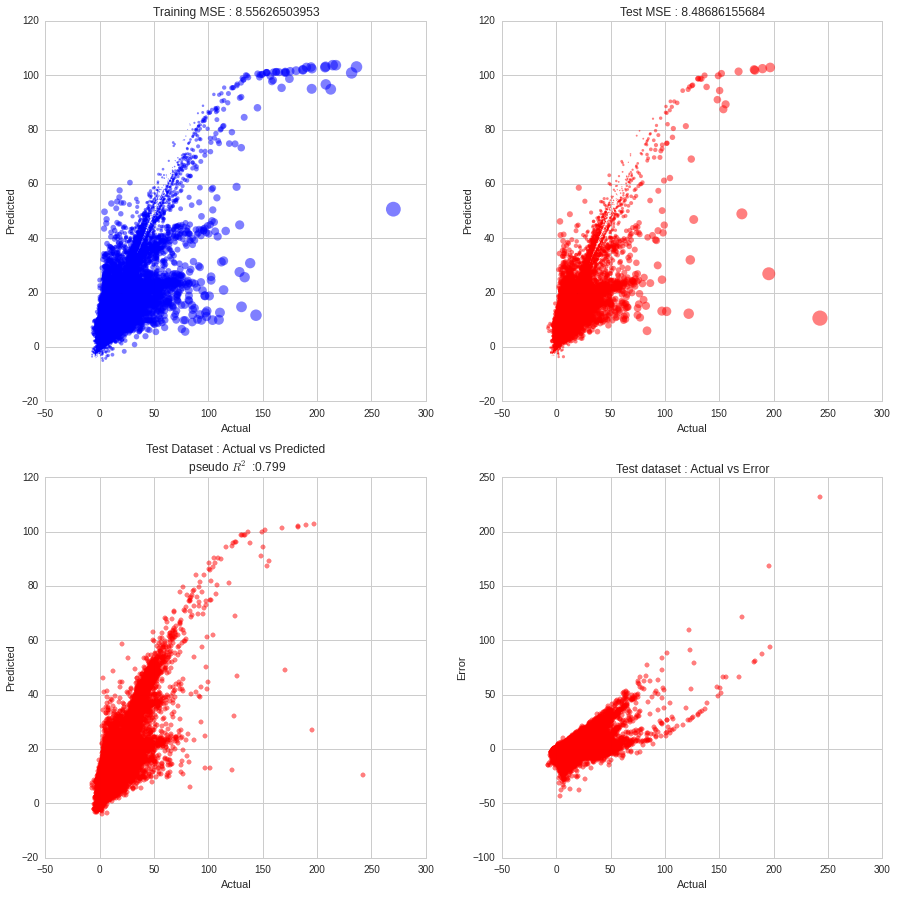

In [89]:
mice_plot = sns.plt.figure(figsize=(15,15))
sns.set_style('whitegrid')


mice_plot.add_subplot(221)
sns.plt.scatter(x_train,
                y_train,
                linewidths=0.0,
                s = abs(error_train),
                c='blue',
                alpha=0.5)
sns.plt.title('Training MSE : '+str(mean_squared_error(x_train,y_train)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(222)
sns.plt.scatter(x_test,
                y_test,
                linewidths=0.0,
                s = abs(error_test),
                c='red',
                alpha=0.5)
sns.plt.title('Test MSE : '+str(mean_squared_error(x_test,y_test)))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(223)
sns.plt.scatter(x_test,
                y_test,
                alpha=0.5,
                color='r')
sns.plt.title('Test Dataset : Actual vs Predicted \n pseudo $R^2$ :'+str(nn_rSquared))
sns.plt.xlabel('Actual')
sns.plt.ylabel('Predicted')

mice_plot.add_subplot(224)
sns.plt.scatter(x_test,
                error_test,
                alpha=0.5,
                color='r')
sns.plt.title('Test dataset : Actual vs Error')
sns.plt.xlabel('Actual')
sns.plt.ylabel('Error')


plt.savefig(path_plot+'si_month_week_aggregates_nn.png',dpi = 450)